In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
import pydotplus
from six import StringIO
from sklearn import preprocessing
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier


In [2]:
fraud=pd.read_csv('/content/Fraud_check.csv')
fraud

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


In [3]:
fraud.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [4]:
# Creating dummy vairables for Categorical columns
fraud=pd.get_dummies(fraud,columns=['Undergrad','Marital.Status','Urban'], drop_first=True)

In [5]:
# Creating new column TaxInc and dividing 'Taxable.Income' cols on the basis of [10002,30000,99620] for Risky and Good
fraud["TaxInc"] = pd.cut(fraud["Taxable.Income"], bins = [10002,30000,99620], labels = ["Risky", "Good"])

In [6]:
fraud

,Taxable.Income,City.Population,Work.Experience,Undergrad_YES,Marital.Status_Married,Marital.Status_Single,Urban_YES,TaxInc
0,68833,50047,10,0,0,1,1,Good
1,33700,134075,18,1,0,0,1,Good
2,36925,160205,30,0,1,0,1,Good
3,50190,193264,15,1,0,1,1,Good
4,81002,27533,28,0,1,0,0,Good
...,...,...,...,...,...,...,...,...
595,76340,39492,7,1,0,0,1,Good
596,69967,55369,2,1,0,0,1,Good
597,47334,154058,0,0,0,0,1,Good
598,98592,180083,17,1,1,0,0,Good


##Lets assume: taxable_income <= 30000 as “Risky=0” and others are “Good=1”

In [7]:
# Creating a new column
fraud = pd.get_dummies(fraud,columns = ["TaxInc"],drop_first=True)

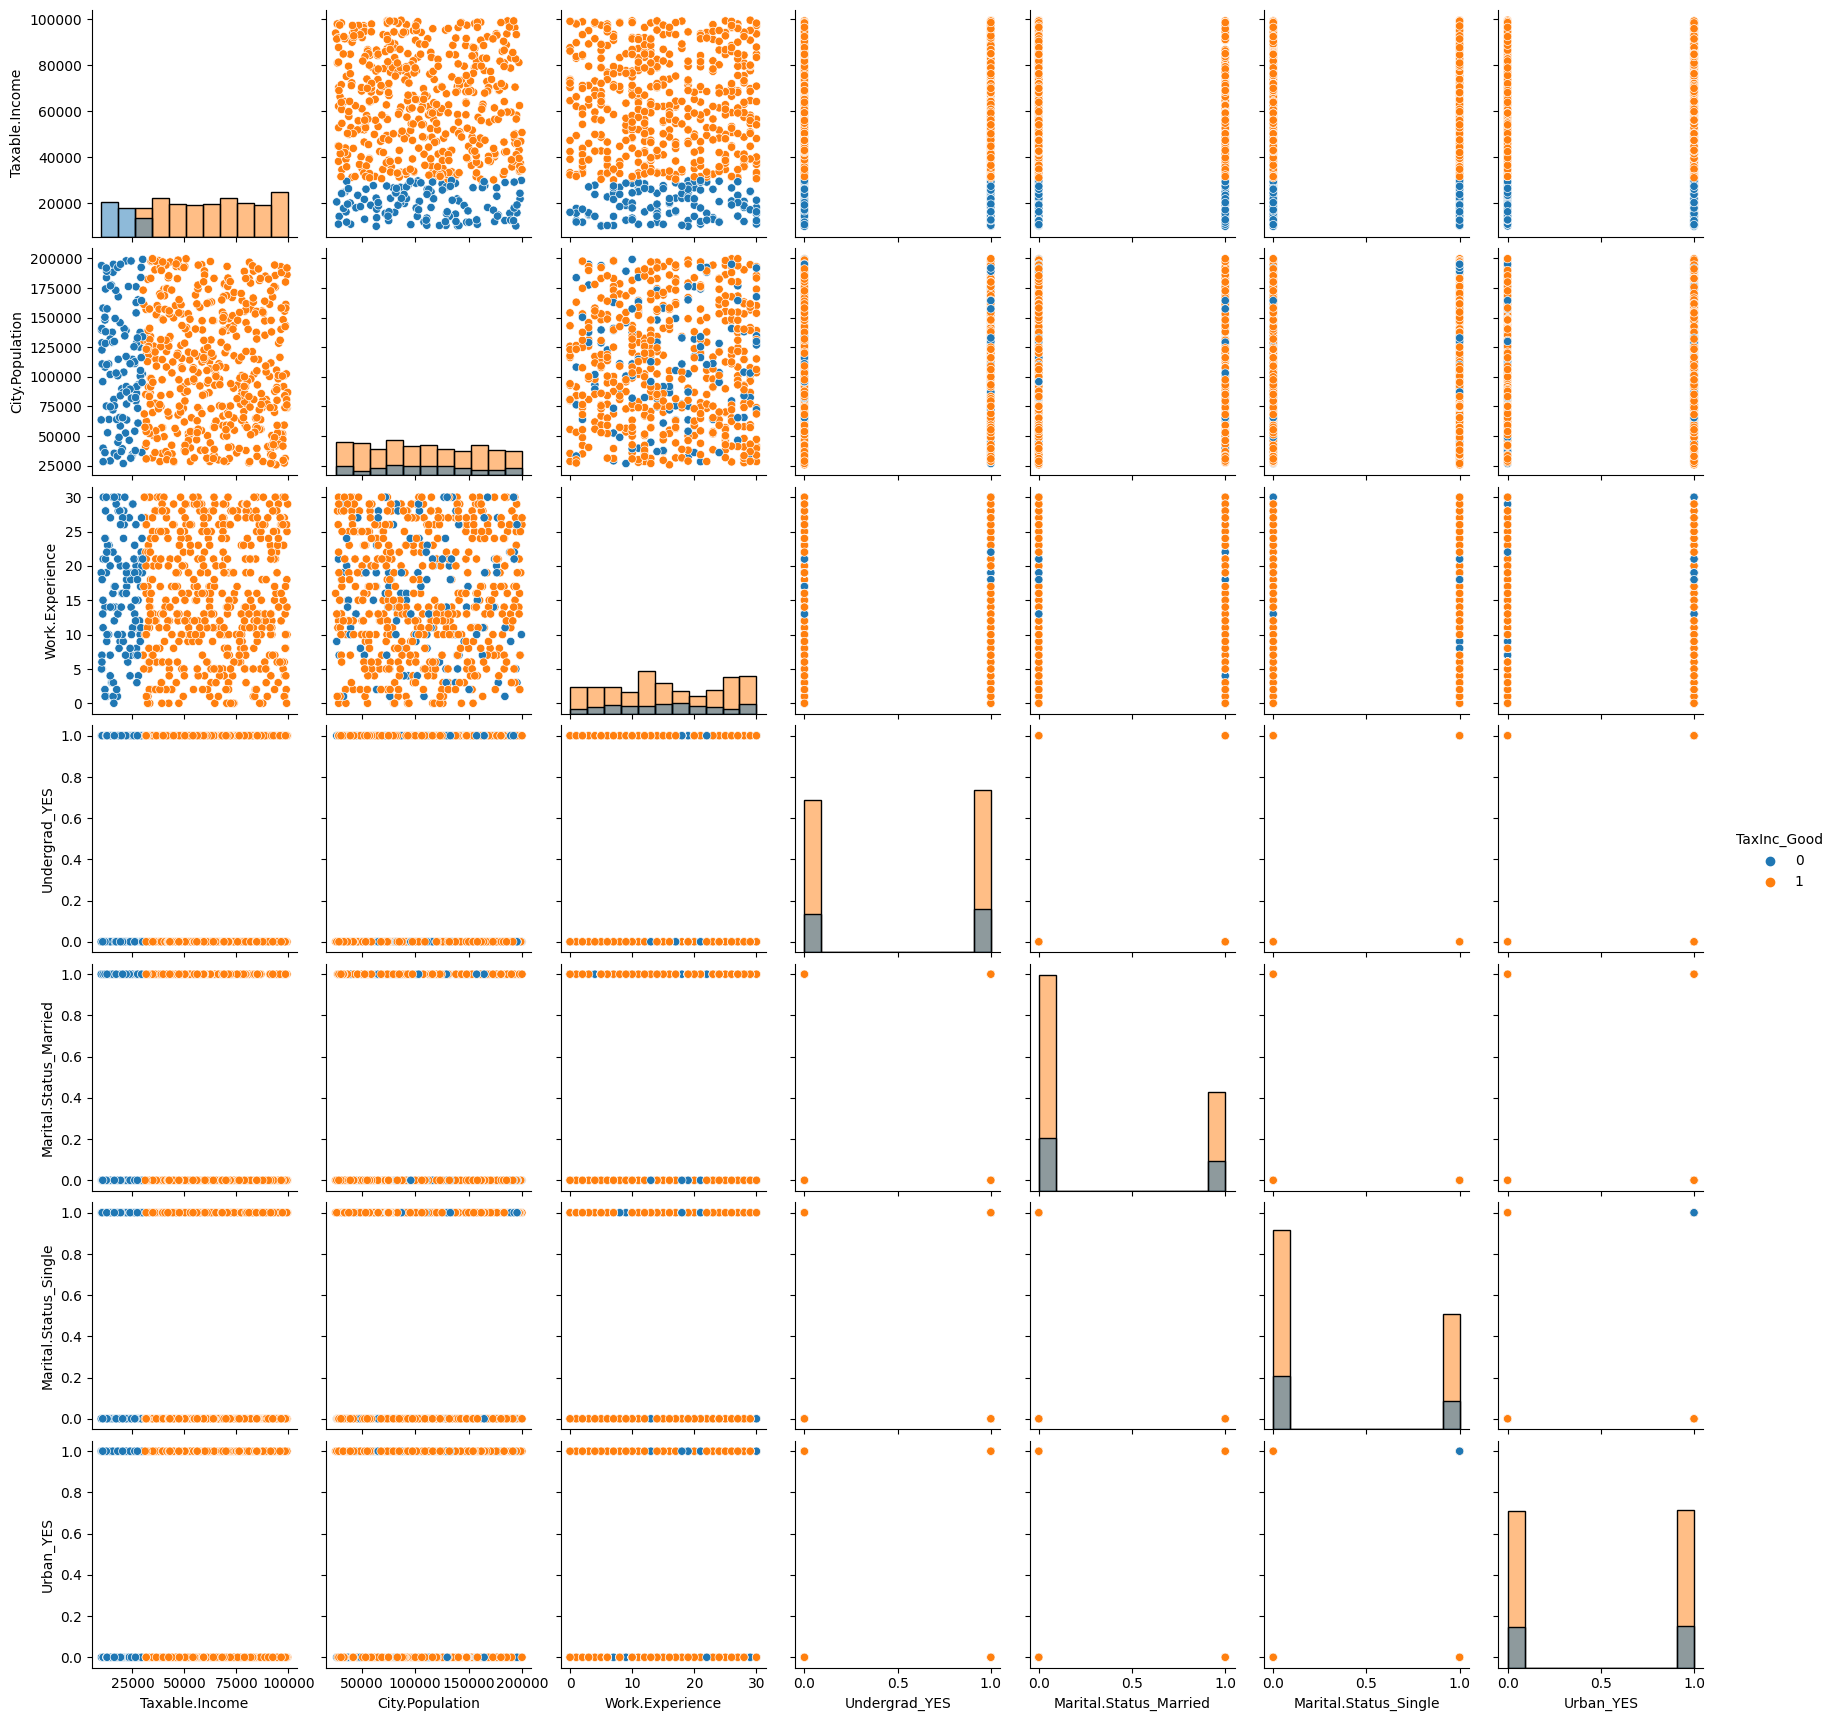

In [8]:
# Pairplot
sns.pairplot(data=fraud, hue = 'TaxInc_Good', diag_kind="hist")

In [9]:
# Defining Normalization function
def norm_func(i):
    x = (i-i.min())/(i.max()-i.min())
    return (x)

In [10]:
# Normaliizng  the data
fraud_norm = norm_func(fraud.iloc[:,1:])
fraud_norm.tail(5)

,City.Population,Work.Experience,Undergrad_YES,Marital.Status_Married,Marital.Status_Single,Urban_YES,TaxInc_Good
595,0.078811,0.233333,1.0,0.0,0.0,1.0,1.0
596,0.170058,0.066667,1.0,0.0,0.0,1.0,1.0
597,0.737240,0.000000,0.0,0.0,0.0,1.0,1.0
598,0.886810,0.566667,1.0,1.0,0.0,0.0,1.0
599,0.760683,0.533333,0.0,0.0,0.0,0.0,1.0


In [11]:
# Declaring features & target
X = fraud_norm.drop(['TaxInc_Good'], axis=1)
y = fraud_norm['TaxInc_Good']

In [12]:
# Splitting data into train & test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
# Converting the Taxable income variable to bucketing.
fraud_norm["income"]="<=30000"
fraud_norm.loc[fraud["Taxable.Income"]>=30000,"income"]="Good"
fraud_norm.loc[fraud["Taxable.Income"]<=30000,"income"]="Risky"

In [14]:
# Droping the Taxable income column
fraud.drop(["Taxable.Income"],axis=1,inplace=True)

In [15]:
#Renaming the columns names
fraud.rename(columns={"Undergrad":"undergrad","Marital.Status":"marital_status","City.Population":"city_population","Work.Experience":"work_experience","Urban":"urban"},inplace=True)


In [16]:
le=preprocessing.LabelEncoder()
for column_name in fraud.columns:
    if fraud[column_name].dtype == object:
        fraud[column_name] = le.fit_transform(fraud[column_name])
    else:
        pass

In [17]:
# Splitting the data into featuers and labels
features = fraud.iloc[:,0:5]
labels = fraud.iloc[:,5]

In [18]:
# Collecting the column names
colnames = list(fraud.columns)
predictors = colnames[0:5]
target = colnames[5]

In [19]:
# Splitting the data into train and test
x_train,x_test,y_train,y_test = train_test_split(features,labels,test_size = 0.2,stratify = labels)

In [20]:
# Creating Model
model = RandomForestClassifier(n_jobs = 3,n_estimators = 15, oob_score = True, criterion = "entropy")
model.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestClassifier(criterion='entropy', n_estimators=15, n_jobs=3,
                       oob_score=True)

In [21]:
model.estimators_
model.classes_
model.n_classes_


2

In [22]:
model.n_outputs_

1

In [23]:
model.oob_score_

0.5145833333333333

In [24]:
# Predictions
prediction = model.predict(x_train)
prediction

array([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,

In [25]:
# Accuracy
accuracy = accuracy_score(y_train,prediction)


In [26]:
np.mean(prediction == y_train)


0.9770833333333333

In [27]:
# Confusion matrix
confusion = confusion_matrix(y_train,prediction)

In [28]:
# Prediction
pred_test = model.predict(x_test)

In [29]:
# Accuracy
acc_test =accuracy_score(y_test,pred_test)
# 78.333%

In [30]:
# Plotting a Decision tree present in Random forest
tree = model.estimators_[5]

In [31]:
dot_data = StringIO()
export_graphviz(tree,out_file = dot_data, filled = True,rounded = True, feature_names = predictors ,class_names = target,impurity =False)


In [32]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


#Building Decision Tree Classifier using Entropy Criteria

In [33]:
model = DecisionTreeClassifier(criterion = 'entropy',max_depth=3)
model.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

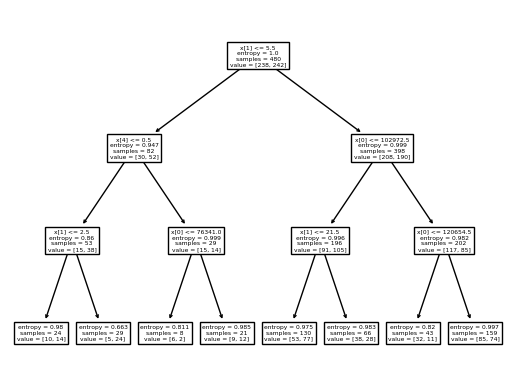

In [34]:
from sklearn import tree
# PLotting the decision tree
tree.plot_tree(model);

In [35]:
colnames = list(fraud.columns)
colnames

['city_population',
 'work_experience',
 'Undergrad_YES',
 'Marital.Status_Married',
 'Marital.Status_Single',
 'Urban_YES',
 'TaxInc_Good']

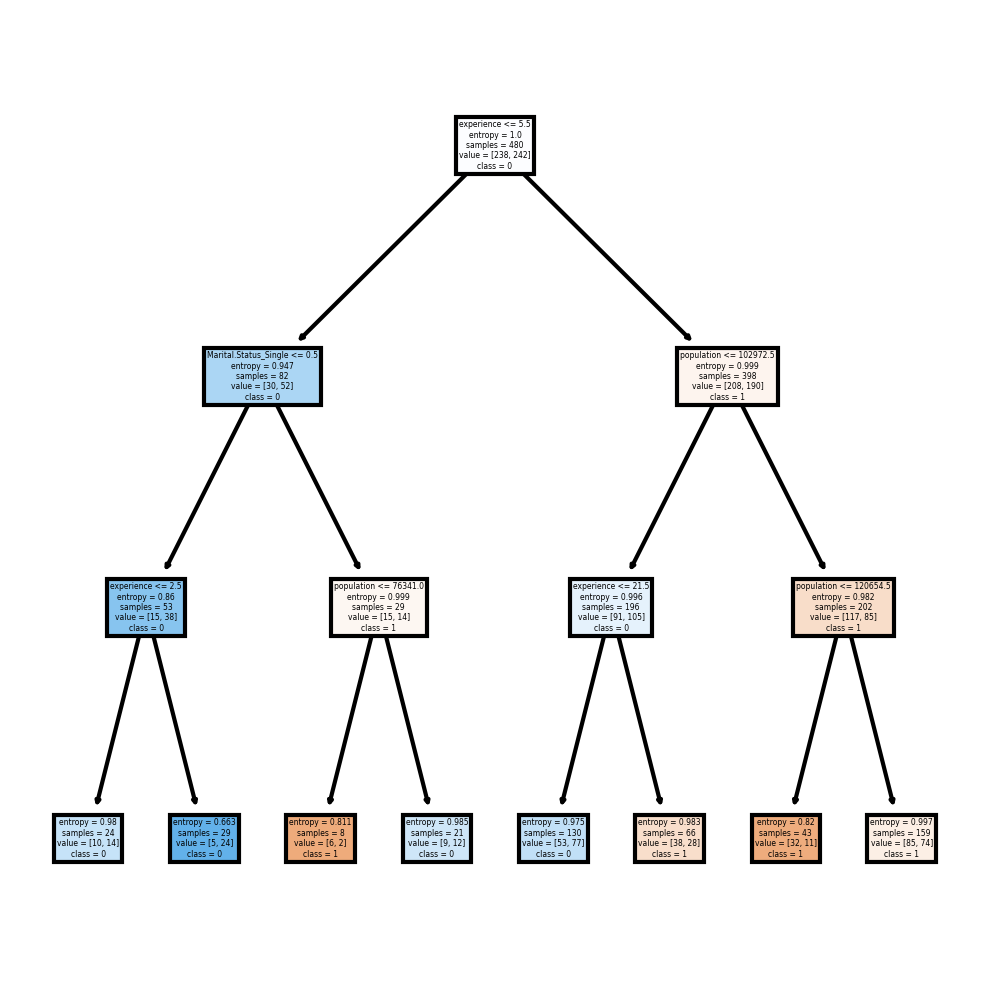

In [36]:
fn=['population','experience','Undergrad_YES','Marital.Status_Married','Marital.Status_Single','Urban_YES']
cn=['1', '0']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(model,
               feature_names = fn,
               class_names=cn,
               filled = True);

In [37]:
# Predicting on test data
preds = model.predict(x_test) # predicting on test data set
pd.Series(preds).value_counts() # getting the count of each category

0    78
1    42
dtype: int64

In [38]:
preds

array([0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0], dtype=uint8)

In [39]:
pd.crosstab(y_test,preds) # getting the 2 way table to understand the correct and wrong predictions

col_0,0,1
Urban_YES,,
0,39,21
1,39,21


In [40]:
# Accuracy
np.mean(preds==y_test)

0.5

#Building Decision Tree Classifier (CART) using Gini Criteria

In [41]:
model_gini = DecisionTreeClassifier(criterion='gini', max_depth=3)
model_gini.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [42]:
# Prediction and computing the accuracy
pred=model.predict(x_test)
np.mean(preds==y_test)

0.5

##Decision Tree Regression

In [43]:
array = fraud.values
X = array[:,0:3]
y = array[:,3]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [45]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [46]:
# Checking the accuracy
model.score(X_test,y_test)

-0.9162779850746272